<a href="https://www.kaggle.com/code/quangnhatbui/age-conditions-eda-and-model-selection?scriptVersionId=132722118" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, make_scorer, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
df_greek = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")

In [3]:
df_train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
df_greek.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [5]:
print(df_train.shape)
print(df_greek.shape)

(617, 58)
(617, 6)


# EDA

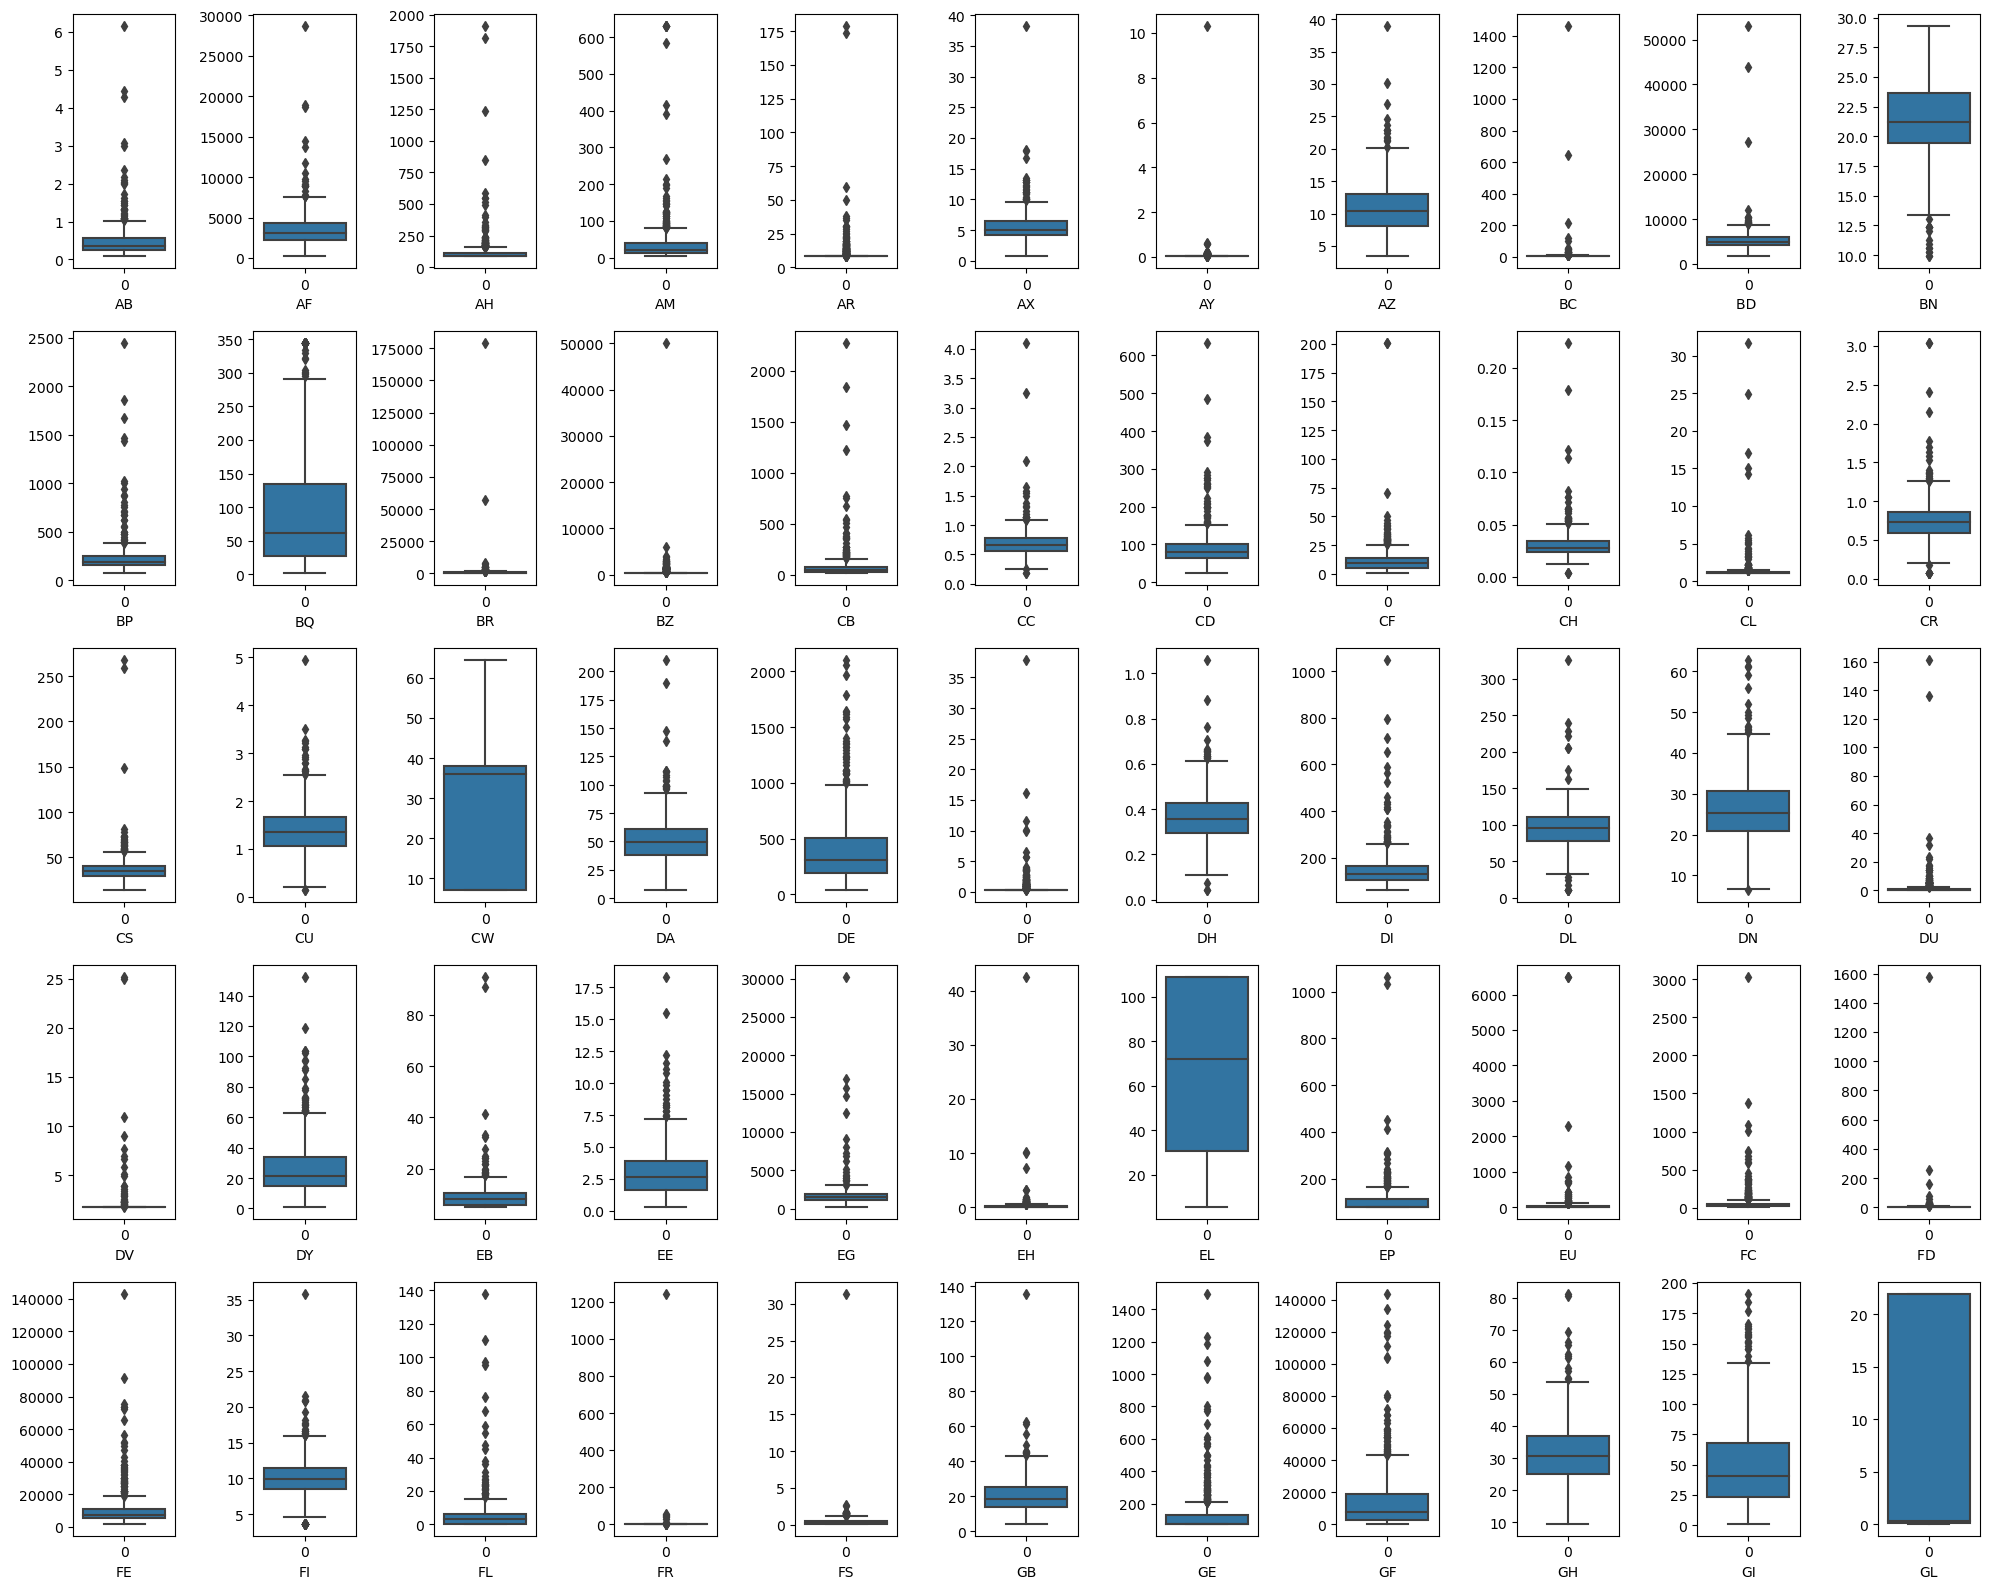

In [6]:
column_names = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']

fig, axes = plt.subplots(nrows=5, ncols=int(len(column_names)/5), figsize=(20,16))

axes = axes.flatten()

for i in range(len(column_names)):
    sns.boxplot(df_train[column_names[i]], ax=axes[i])
    axes[i].set_xlabel(column_names[i])
    
fig.tight_layout()
plt.show()

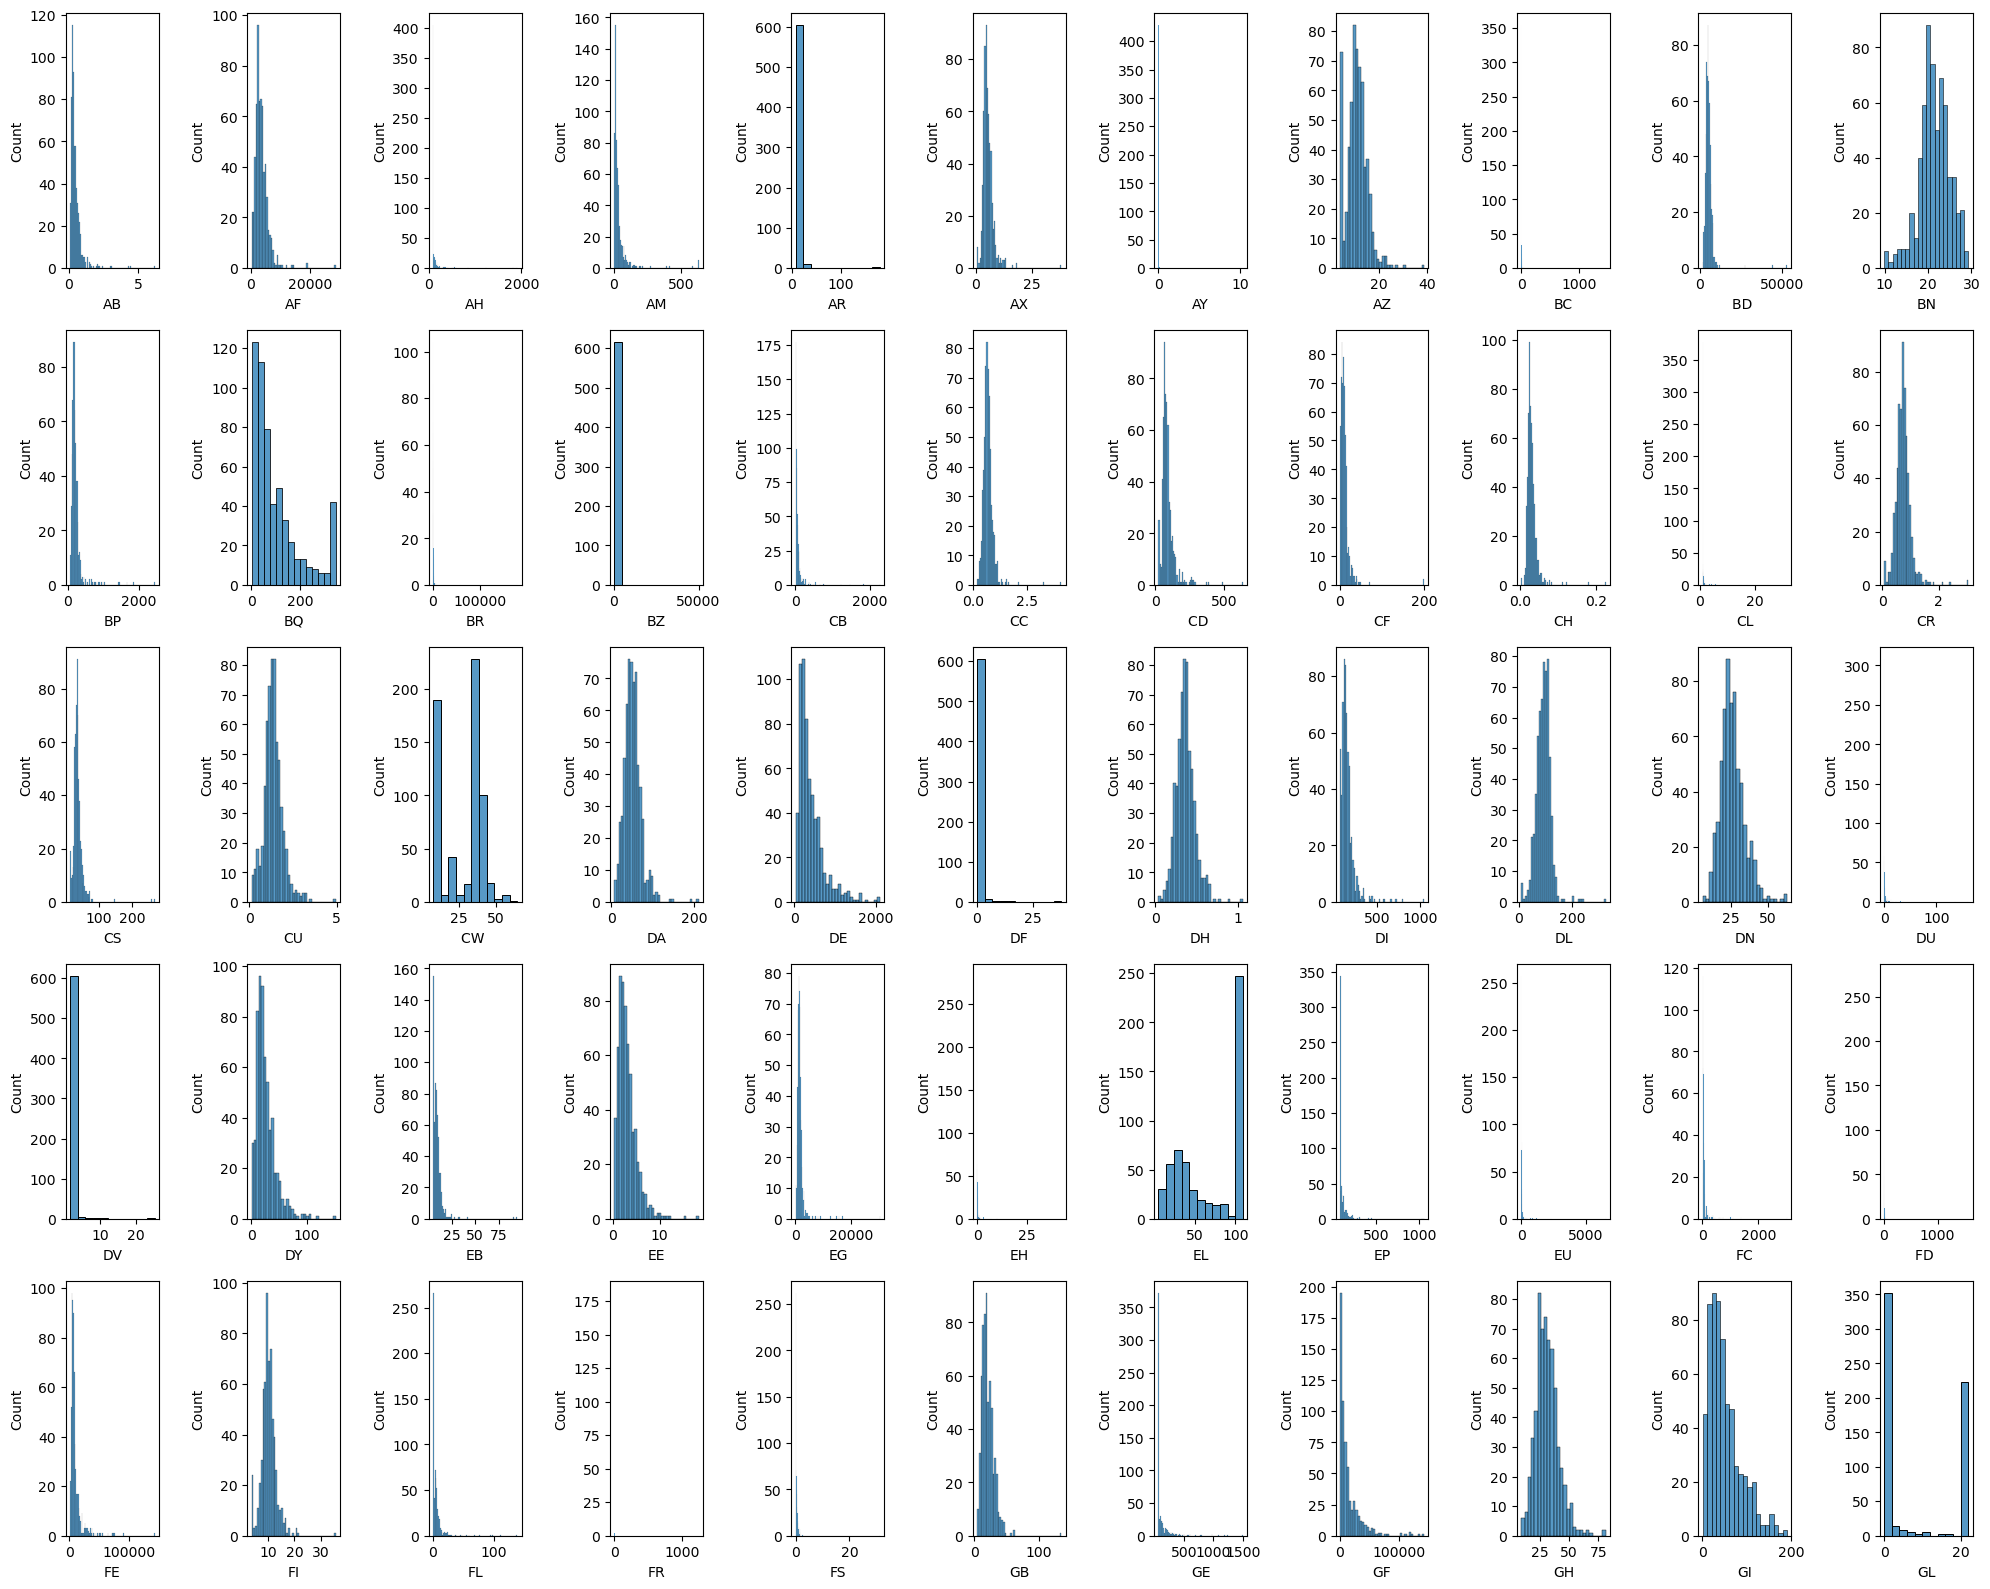

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=int(len(column_names)/5), figsize=(20,16))

axes = axes.flatten()

for i in range(len(column_names)):
    sns.histplot(df_train[column_names[i]], ax=axes[i])
    axes[i].set_xlabel(column_names[i])
    
fig.tight_layout()
plt.show()

In [8]:
# From the plots, we can see that there are a lot of outliers
# Get the outliers for each column
outliers = {}
for i in range(len(column_names)):
    q1 = df_train[column_names[i]].quantile(0.25)
    q3 = df_train[column_names[i]].quantile(0.75)
    
    upper = q3 + (q3-q1)*1.5
    lower = q1 - (q3-q1)*1.5
    
    outliers_count = np.sum(df_train[column_names[i]] > upper)
    outliers[column_names[i]] = outliers_count

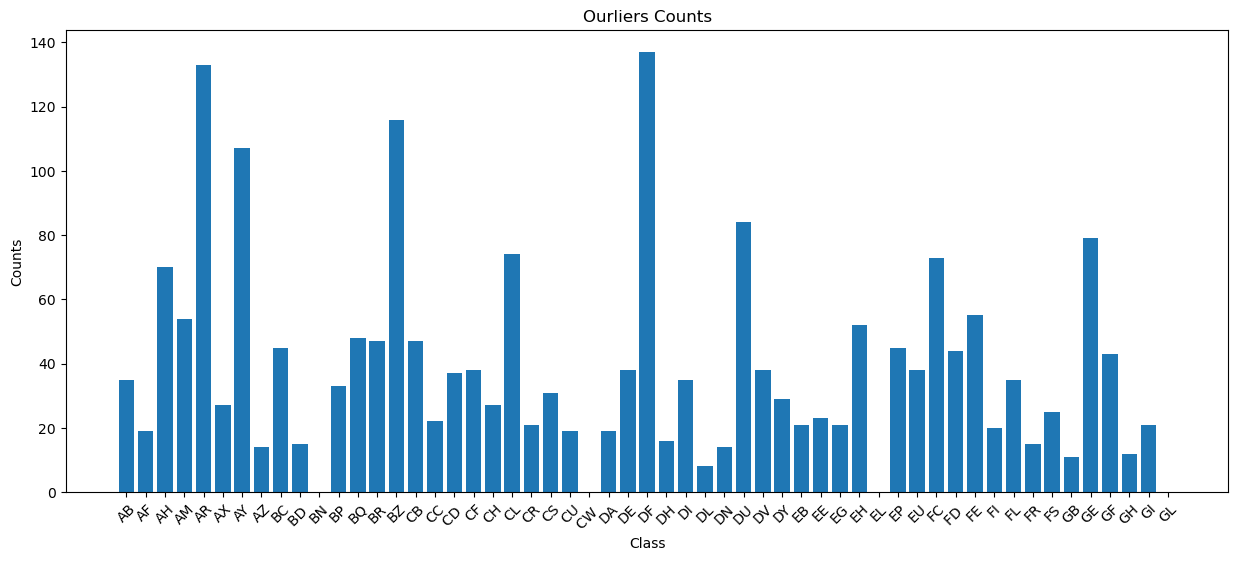

In [9]:
# As we can see there are a lot of outliers compare to the total number of examples, this suggest that we should use Robust Scaler
plt.figure(figsize=(15, 6))
plt.bar(outliers.keys(),outliers.values())

plt.title("Ourliers Counts")
plt.xlabel("Class")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.show()

Text(0, 0.5, 'Count')

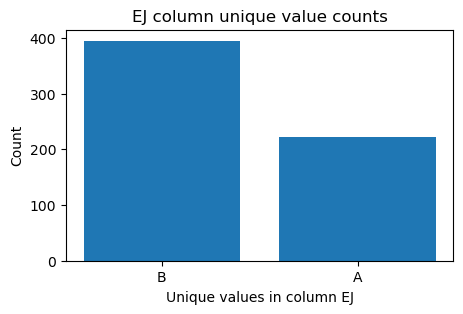

In [10]:
ej_valuecounts = df_train["EJ"].value_counts()
ej_xaxis = ej_valuecounts.index
ej_yaxis = ej_valuecounts.values

plt.figure(figsize=(5,3))
plt.bar(ej_xaxis, ej_yaxis)

plt.title("EJ column unique value counts")
plt.xlabel("Unique values in column EJ")
plt.ylabel("Count")

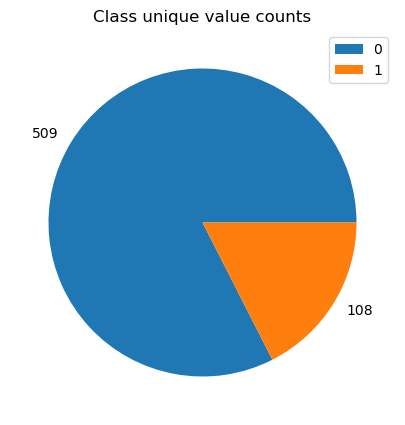

In [11]:
# From the chart, we can see that there are significantly more class 0 than class 1, hence later we should consider using stratified kfold and upsampling technique
class_valuecounts = df_train["Class"].value_counts()
class_xaxis = class_valuecounts.index
class_yaxis = class_valuecounts.values

plt.figure(figsize=(8,5))
plt.pie(class_yaxis, labels=class_yaxis)

plt.legend(class_xaxis)
plt.title("Class unique value counts")
plt.show()

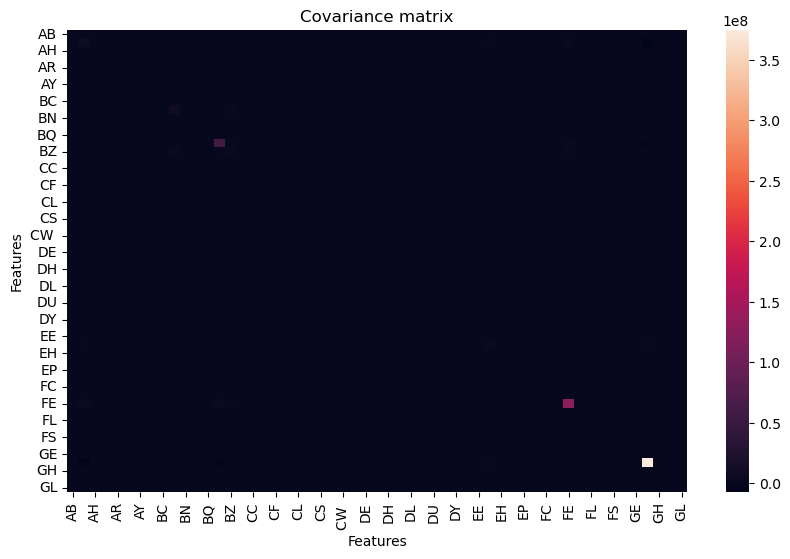

In [12]:
# From covariance matrix, you can see that only 3 features that are deeply correlated to each other, hence consider using PCA with around 3-5 components
cov_matrix = df_train.iloc[:, :-1].cov(numeric_only=True)

plt.figure(figsize=(10,6))
sns.heatmap(cov_matrix)
plt.title("Covariance matrix")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

# Data Preprocessing

First we will deal with NaNs values

In [13]:
df_train.isnull().sum()

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [14]:
# Since the dataset have 617 instances, drop more than 60 instaces would be too much, hence we will opt for the option of replacing them with means since all of the 
# missing values are in numerical columns
df_train = df_train.fillna(df_train.mean(numeric_only=True))
df_train["EJ"] = df_train["EJ"].fillna(df_train["EJ"].mode())

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      617 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      617 non-null    float64
 17  CC      617 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [16]:
# There are 1 categorical column, let's investigate
np.unique(df_train["EJ"].values)

array(['A', 'B'], dtype=object)

In [17]:
## We will use one hot encoding since these are nominal data. A common practice of one-hot encoding is to remove 1 column to reduce multicollinearity
# ej_train = pd.get_dummies(df_train["EJ"])
# if len(ej_train.columns) > 1:
#     ej_train = ej_train.iloc[:,1:]

In [18]:
# X_train = df_train.drop("EJ", axis=1)
# X_train.reset_index(drop=True, inplace=True)
# X_train = pd.concat([X_train, ej_train], ignore_index=True, axis=1)

In [19]:
# I am trying Ordinal Encoder since my submission is keep giving me Threw error
ordinal_encode = OrdinalEncoder()
df_train["EJ"] = ordinal_encode.fit_transform(df_train.loc[:, ["EJ"]])

In [20]:
y_train = df_train["Class"]
X_train = df_train.drop(["Class", "EJ"], axis=1) #### Dropping at the moment to avoid error

In [21]:
X_train = X_train.iloc[:, 1:]

In [22]:
pca = PCA(n_components=None)
X_train_trans = pca.fit_transform(X_train)
explained_var_train = pca.explained_variance_ratio_

In [23]:
explained_ratio = list(explained_var_train*100 / sum(explained_var_train))
explained_ratio_int = []
for i in range(len(explained_ratio)):
    explained_ratio_int.append(int(explained_ratio[i]))

In [24]:
explained_ratio_int

[64,
 22,
 9,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [25]:
# Trying to upsample my dataset
X_upsampled, y_upsampled = resample(X_train[y_train==1], y_train[y_train==1], replace=True, n_samples=y_train[y_train==0].shape[0], random_state=1)
X_bal = pd.DataFrame(np.vstack((X_train[y_train==0], X_upsampled)))
y_bal = pd.DataFrame(np.hstack((y_train[y_train==0], y_upsampled)))[0]

# MODEL SELECTION

In [26]:
def learning_curve_plot(train_sizes, train_scores, test_scores):
    '''This function plot the leaning curve given the train sizes, train scores, and test scores'''
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean, color="blue", marker='o', markersize=5, label="Training Accuracy")
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color="blue")
    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Testing Accuracy')
    plt.fill_between(train_sizes, test_mean + train_std, test_mean - test_std, alpha=0.15, color="green")
    
    plt.grid()
    plt.xlabel("Number of training examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.show()

In [27]:
def scores(scorer, estimator, X_train, y_train, validation_strats):
    '''Given the scorer, estimator, training dataset and validation strategy, model will
    return the scores'''
    scorer_define = make_scorer(scorer)
    scorer_scores = cross_val_score(estimator=estimator, X=X_train, y=y_train, cv=validation_strats, scoring=scorer_define)
    return scorer_scores

In [28]:
# I'm using pipeline instead of trying the individual model because Logistic regression won't converge
pipe_lr = make_pipeline(RobustScaler(), PCA(n_components=3), LogisticRegression(random_state=1, C=1/0.01, solver='lbfgs', class_weight='balanced'))
pipe_rf = make_pipeline(RobustScaler(), PCA(n_components=3), RandomForestClassifier(criterion='gini', n_estimators=200, random_state=1, n_jobs=2))
pipe_svm = make_pipeline(RobustScaler(), PCA(n_components=3), SVC(C=1/0.01, gamma=0.001, kernel='rbf'))
pipe_knn = make_pipeline(RobustScaler(), PCA(n_components=3), KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski'))

In [29]:
# pipe_lr = LogisticRegression(random_state=1, C=1/0.01, solver='lbfgs', class_weight='balanced')
# pipe_rf = RandomForestClassifier(criterion='gini', n_estimators=200, random_state=1, n_jobs=2)

In [30]:
stratified_kfold = StratifiedKFold(n_splits=10)
scores_lr = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=stratified_kfold)
print("Accuracy score: ")
print(scores_lr)

Accuracy score: 
[0.80645161 0.56451613 0.74193548 0.58064516 0.72580645 0.59677419
 0.72580645 0.78688525 0.68852459 0.70491803]


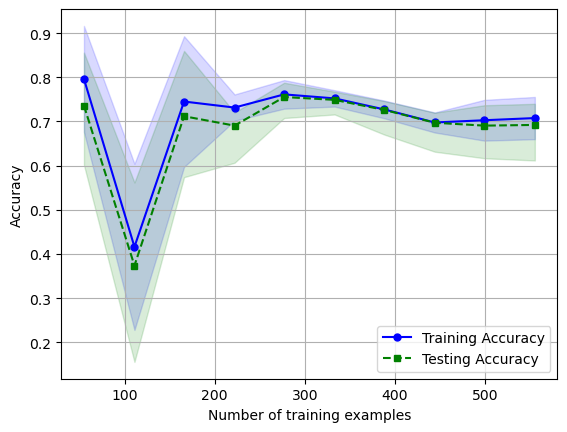

In [31]:
# From this, we known that the model has good variance but high bias
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1,1,10), cv=stratified_kfold)
learning_curve_plot(train_sizes, train_scores, test_scores)

In [32]:
# Logistic regression seems like doing very poor,let's try another model
print("F1 score: ")
print(scores(f1_score, pipe_lr, X_train, y_train, stratified_kfold).mean())
print("ROCAUC score: ")
print(scores(roc_auc_score, pipe_lr, X_train, y_train, stratified_kfold).mean())
print("Logloss score: ")
print(scores(log_loss, pipe_lr, X_train, y_train, stratified_kfold).mean())

F1 score: 
0.3464043371594757
ROCAUC score: 
0.5982299465240641
Logloss score: 
11.093287293742033


In [33]:
scores_rf = cross_val_score(estimator=pipe_rf, X=X_train, y=y_train, cv=stratified_kfold)
print("Accuracy score: ")
print(scores_rf.mean())
print("F1 score: ")
print(scores(f1_score, pipe_rf, X_train, y_train, stratified_kfold).mean())
print("ROCAUC score: ")
print(scores(roc_auc_score, pipe_rf, X_train, y_train, stratified_kfold).mean())
print("Logloss score: ")
print(scores(log_loss, pipe_rf, X_train, y_train, stratified_kfold).mean())

Accuracy score: 
0.8330248545742993
F1 score: 
0.3246828609986504
ROCAUC score: 
0.6079055258467022
Logloss score: 
6.018394266321385


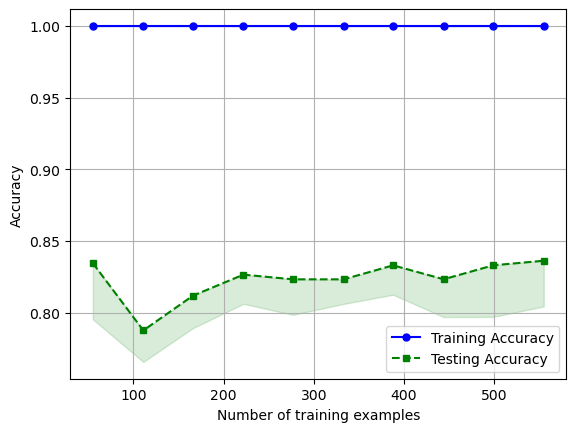

In [34]:
# it looks like random forest is overfit
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_rf, X=X_train, y=y_train, train_sizes=np.linspace(0.1,1,10), cv=stratified_kfold)
learning_curve_plot(train_sizes, train_scores, test_scores)

In [35]:
# Extremely poor in F1 score and ROCAUC score, almost worse than random guess for ROCAUC
scores_svm = cross_val_score(estimator=pipe_svm, X=X_train, y=y_train, cv=stratified_kfold)
print("Accuracy score: ")
print(scores_rf.mean())
print("F1 score: ")
print(scores(f1_score, pipe_svm, X_train, y_train, stratified_kfold).mean())
print("ROCAUC score: ")
print(scores(roc_auc_score, pipe_svm, X_train, y_train, stratified_kfold).mean())
print("Logloss score: ")
print(scores(log_loss, pipe_svm, X_train, y_train, stratified_kfold).mean())

Accuracy score: 
0.8330248545742993
F1 score: 
0.045238095238095244
ROCAUC score: 
0.5003458110516934
Logloss score: 
6.9504591265687825


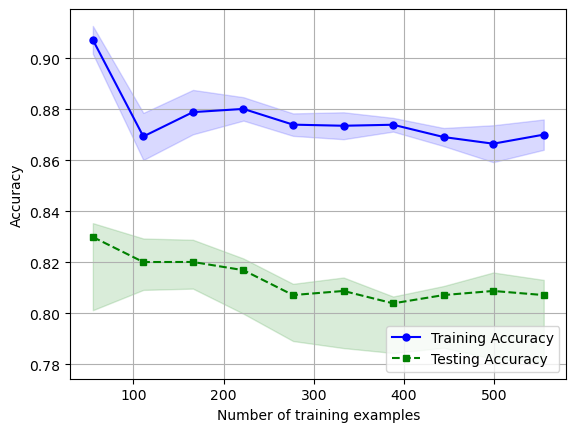

In [36]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_svm, X=X_train, y=y_train, train_sizes=np.linspace(0.1,1,10), cv=stratified_kfold)
learning_curve_plot(train_sizes, train_scores, test_scores)

In [37]:
# KNN suffers the same thing as SVM
scores_knn = cross_val_score(estimator=pipe_knn, X=X_train, y=y_train, cv=stratified_kfold)
print("Accuracy score: ")
print(scores_rf.mean())
print("F1 score: ")
print(scores(f1_score, pipe_knn, X_train, y_train, stratified_kfold).mean())
print("ROCAUC score: ")
print(scores(roc_auc_score, pipe_knn, X_train, y_train, stratified_kfold).mean())
print("Logloss score: ")
print(scores(log_loss, pipe_knn, X_train, y_train, stratified_kfold).mean())

Accuracy score: 
0.8330248545742993
F1 score: 
0.1406787330316742
ROCAUC score: 
0.532716577540107
Logloss score: 
6.774148288996422


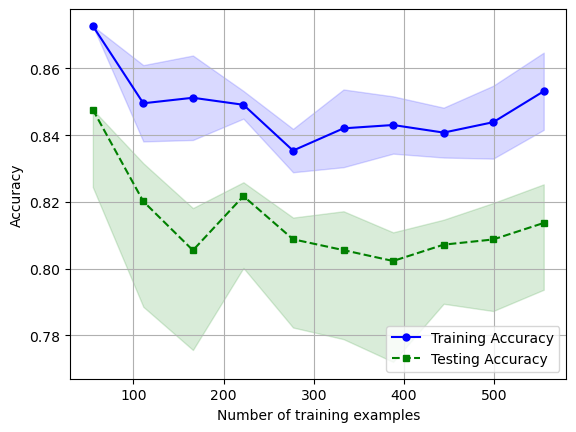

In [38]:
# Poor in both bias and variance
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_knn, X=X_train, y=y_train, train_sizes=np.linspace(0.1,1,10), cv=stratified_kfold)
learning_curve_plot(train_sizes, train_scores, test_scores)

It seems like Random Forest is giving us the best result here, except the fact that it is overfitting. It's poor performance in F1 and ROC AUC, while doing well in training accuracy score tell us that it is heavily affected by the unbalanced class proportion. Let's fix it.

In [39]:
# So upsampling the data seems to work very well
scores_rf = cross_val_score(estimator=pipe_rf, X=X_bal, y=y_bal, cv=stratified_kfold)
print("Accuracy score: ")
print(scores_rf.mean())
print("F1 score: ")
print(scores(f1_score, pipe_rf, X_bal, y_bal, stratified_kfold).mean())
print("ROCAUC score: ")
print(scores(roc_auc_score, pipe_rf, X_bal, y_bal, stratified_kfold).mean())
print("Logloss score: ")
print(scores(log_loss, pipe_rf, X_bal, y_bal, stratified_kfold).mean())

Accuracy score: 
0.9410794020578528
F1 score: 
0.9440192956377829
ROCAUC score: 
0.9410980392156864
Logloss score: 
2.1237136097062814


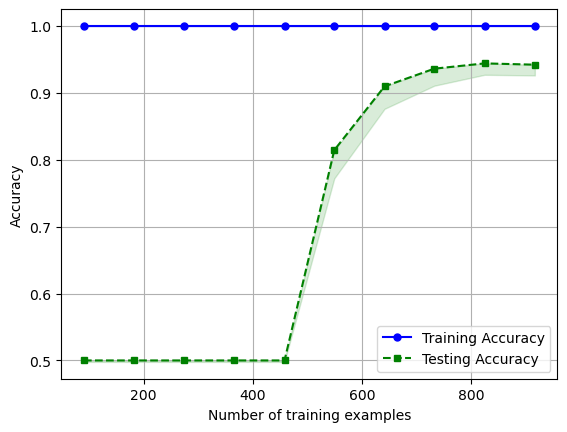

In [40]:
# The overfitting problem seems to significantly better
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_rf, X=X_bal, y=y_bal, train_sizes=np.linspace(0.1,1,10), cv=stratified_kfold)
learning_curve_plot(train_sizes, train_scores, test_scores)

In [41]:
# After deciding on using random forest, I want to tryout different the PCA, the Scaler
pipe_rf_robust = make_pipeline(RobustScaler(), PCA(), RandomForestClassifier(criterion='gini', n_estimators=200, random_state=1, n_jobs=2))
param_criterion = ["gini", "entropy"]
param_n_estimators = [300, 500, 800]
param_n_components = [3,5,7,9,11,15,20,25]
param_grid = {"pca__n_components":param_n_components,"randomforestclassifier__criterion": param_criterion, "randomforestclassifier__n_estimators": param_n_estimators}
scoring = {"roc_auc": make_scorer(roc_auc_score), "f1_score": make_scorer(f1_score), "log_loss": make_scorer(log_loss)}
gs_robust_pca = GridSearchCV(estimator=pipe_rf_robust, param_grid=param_grid, scoring=scoring, refit="log_loss", cv=stratified_kfold)

In [42]:
gs_robust_pca = gs_robust_pca.fit(X_bal, y_bal)
print(gs_robust_pca.best_params_)
print(gs_robust_pca.best_score_)

{'pca__n_components': 3, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 800}
2.2297243549683907


In [43]:
pipe_rf_robust = make_pipeline(RobustScaler(), KernelPCA(), RandomForestClassifier(criterion='gini', n_estimators=200, random_state=1, n_jobs=2))
param_grid_kpca = {"kernelpca__n_components":param_n_components,"randomforestclassifier__criterion": param_criterion, "randomforestclassifier__n_estimators": param_n_estimators}
gs_robust_kpca = GridSearchCV(estimator=pipe_rf_robust, param_grid=param_grid_kpca, scoring=scoring, refit="log_loss", cv=stratified_kfold)

In [44]:
gs_robust_kpca = gs_robust_kpca.fit(X_bal, y_bal)
print(gs_robust_kpca.best_params_)
print(gs_robust_kpca.best_score_)

{'kernelpca__n_components': 3, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 800}
2.2297243549683907


In [45]:
pipe_rf_standard = make_pipeline(StandardScaler(), PCA(), RandomForestClassifier(criterion='gini', n_estimators=200, random_state=1, n_jobs=2))
gs_standard_pca = GridSearchCV(estimator=pipe_rf_standard, param_grid=param_grid, scoring=scoring, refit="log_loss", cv=stratified_kfold)

In [46]:
gs_standard_pca = gs_standard_pca.fit(X_bal, y_bal)
print(gs_standard_pca.best_params_)
print(gs_standard_pca.best_score_)

{'pca__n_components': 3, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 800}
1.9470290342694327


In [47]:
pipe_rf_standard = make_pipeline(StandardScaler(), KernelPCA(), RandomForestClassifier(criterion='gini', n_estimators=200, random_state=1, n_jobs=2))
gs_standard_kpca = GridSearchCV(estimator=pipe_rf_robust, param_grid=param_grid_kpca, scoring=scoring, refit="log_loss", cv=stratified_kfold)

In [48]:
gs_standard_kpca = gs_standard_kpca.fit(X_bal, y_bal)
print(gs_standard_kpca.best_params_)
print(gs_standard_kpca.best_score_)

{'kernelpca__n_components': 3, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 800}
2.2297243549683907


In [49]:
pipe_rf_best = make_pipeline(StandardScaler(), PCA(n_components=3), RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=1, n_jobs=2))
scores_rf = cross_val_score(estimator=pipe_rf_best, X=X_bal, y=y_bal, cv=stratified_kfold)
print("Accuracy score: ")
print(scores_rf.mean())
print("F1 score: ")
print(scores(f1_score, pipe_rf, X_bal, y_bal, stratified_kfold).mean())
print("ROCAUC score: ")
print(scores(roc_auc_score, pipe_rf, X_bal, y_bal, stratified_kfold).mean())
print("Logloss score: ")
print(scores(log_loss, pipe_rf, X_bal, y_bal, stratified_kfold).mean())

Accuracy score: 
0.9489225393127547
F1 score: 
0.9440192956377829
ROCAUC score: 
0.9410980392156864
Logloss score: 
2.1237136097062814


# Result

In [50]:
pipe_rf.fit(X_bal, y_bal.values.flatten())

Pipeline(steps=[('robustscaler', RobustScaler()), ('pca', PCA(n_components=3)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=200, n_jobs=2,
                                        random_state=1))])

In [51]:
df_test = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")

In [52]:
df_test = df_test.fillna(df_test.mean(numeric_only=True))
df_test["EJ"] = df_test["EJ"].fillna(df_train["EJ"].mode())

In [53]:
# ej_test = pd.get_dummies(df_test["EJ"])
# if len(ej_df.columns) > 1:
#     ej_df = ej_df.iloc[:, 1:]
# X_test = df_test.drop("EJ", axis=1)\
# df_test = pd.concat([X_test, ej_df], ignore_index=True, axis=1)

In [54]:
df_test["EJ"] = ordinal_encode.fit_transform(df_test.loc[:, ["EJ"]])

In [55]:
df_test.drop(["EJ"], axis=1, inplace=True)

In [56]:
df_test.reset_index(drop=True, inplace=True)

In [57]:
X_test = df_test.iloc[:, 1:]

In [58]:
X_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
output = pipe_rf.predict_proba(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


In [60]:
df_test["class_0"] = output[:, 0]

In [61]:
df_test["class_1"] = output[:, 1]

In [62]:
output = df_test[["Id", "class_0", "class_1"]]

In [63]:
output.to_csv('submission.csv', index=False)

In [64]:
output

,Id,class_0,class_1
0,00eed32682bb,0.815,0.185
1,010ebe33f668,0.815,0.185
2,02fa521e1838,0.815,0.185
3,040e15f562a2,0.815,0.185
4,046e85c7cc7f,0.815,0.185
